In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Phase 2 strategies + regime features
# -------------------------------
from phase_2.scripts.strategies.trend.trend_strategy_v1 import run_trend_strategy_v1
from phase_2.scripts.strategies.meanrev.meanrev_strategy_v1 import run_meanrev_strategy_v1
from phase_2.scripts.strategies.meta.meta_allocator_v1 import (
    build_regime_features,
    build_meta_raw_returns_param_v1,
)

# -------------------------------
# Phase 3 hysteresis allocator
# -------------------------------
from phase_3.strategies.meta.meta_allocator_hysteresis_v1 import (
    build_meta_raw_returns_hysteresis_v1,
    DEFAULT_HYST_PARAMS,
)

# -------------------------------
# Portfolio plumbing (Phase 2)
# -------------------------------
from phase_2.scripts.strategies.meta.risk_targeting_v1 import apply_vol_targeting
from phase_2.scripts.strategies.portfolio.portfolio_constructor_v1 import (
    align_asset_returns,
    compute_inverse_vol_weights,
    build_portfolio_raw_returns,
)


In [2]:
ASSETS = ["SPY", "AAPL", "MSFT"]

data = {}
for sym in ASSETS:
    df = pd.read_parquet(f"../../phase_2/data/processed/{sym.lower()}_daily.parquet")
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    df["year"] = df["date"].dt.year
    data[sym] = df

years = sorted(data["SPY"]["year"].unique())
years[:5], years[-5:]


([np.int32(2010),
  np.int32(2011),
  np.int32(2012),
  np.int32(2013),
  np.int32(2014)],
 [np.int32(2022),
  np.int32(2023),
  np.int32(2024),
  np.int32(2025),
  np.int32(2026)])

In [3]:
HARD_PARAMS_TIGHT = {
    "trend_mom60_min": 0.0,
    "trend_mom20_min": -0.005,
    "meanrev_mom20_max": -0.025,
    "meanrev_dd60_max": -0.03,
    "meanrev_vol20_max": 0.40,
}


In [4]:
def sharpe_ratio(x):
    x = np.asarray(x, dtype=float)
    if np.nanstd(x) == 0:
        return np.nan
    return np.sqrt(252) * np.nanmean(x) / np.nanstd(x)

def max_drawdown(eq):
    eq = np.asarray(eq, dtype=float)
    peak = np.maximum.accumulate(eq)
    dd = eq / peak - 1.0
    return np.nanmin(dd)


In [5]:
def run_portfolio_walkforward(mode: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      portfolio_daily: date, portfolio_ret, portfolio_lev, year
      diag: date, asset, year, state (for allocator diagnostics)
    """
    portfolio_all = []
    diag_all = []

    for test_year in years:
        asset_daily = {}
        diag_year = []

        for sym, df in data.items():
            train = df[df["year"] < test_year].copy()
            test  = df[df["year"] == test_year].copy()

            if len(train) < 500 or len(test) < 60:
                continue

            trend_out = run_trend_strategy_v1(test, train_df=train)
            meanrev_out = run_meanrev_strategy_v1(test)
            regime = build_regime_features(test)

            if mode == "hard_tight":
                meta = build_meta_raw_returns_param_v1(trend_out, meanrev_out, regime, HARD_PARAMS_TIGHT)

            elif mode == "hyst":
                meta = build_meta_raw_returns_hysteresis_v1(trend_out, meanrev_out, regime, p=DEFAULT_HYST_PARAMS)

            else:
                raise ValueError(f"Unknown mode: {mode}")

            meta["asset"] = sym
            meta["year"] = test_year

            asset_daily[sym] = meta[["date", "asset", "year", "state", "meta_raw_ret"]]
            diag_year.append(asset_daily[sym])

        if len(asset_daily) != len(ASSETS):
            continue

        # Portfolio construction (same)
        ret_wide = align_asset_returns(asset_daily)
        w_assets = compute_inverse_vol_weights(ret_wide, lookback=20, max_weight=0.70)
        port_raw = build_portfolio_raw_returns(ret_wide, w_assets)

        # Portfolio-level vol targeting (same)
        vt = apply_vol_targeting(port_raw, target_vol_annual=0.10, lookback=20, max_leverage=1.0)

        port = pd.DataFrame({
            "date": port_raw.index,
            "portfolio_raw_ret": port_raw.values,
            "portfolio_lev": vt["lev"].values,
            "portfolio_ret": vt["meta_ret"].values,
            "year": test_year,
        })

        portfolio_all.append(port)
        diag_all.append(pd.concat(diag_year, ignore_index=True))

    portfolio_daily = pd.concat(portfolio_all).sort_values("date").reset_index(drop=True)
    diag = pd.concat(diag_all).sort_values(["date", "asset"]).reset_index(drop=True)

    return portfolio_daily, diag


In [6]:
port_hard, diag_hard = run_portfolio_walkforward("hard_tight")
port_hyst, diag_hyst = run_portfolio_walkforward("hyst")

print(len(port_hard), port_hard["date"].min(), port_hard["date"].max())
print(len(port_hyst), port_hyst["date"].min(), port_hyst["date"].max())


3520 2012-01-03 00:00:00 2025-12-31 00:00:00
3520 2012-01-03 00:00:00 2025-12-31 00:00:00


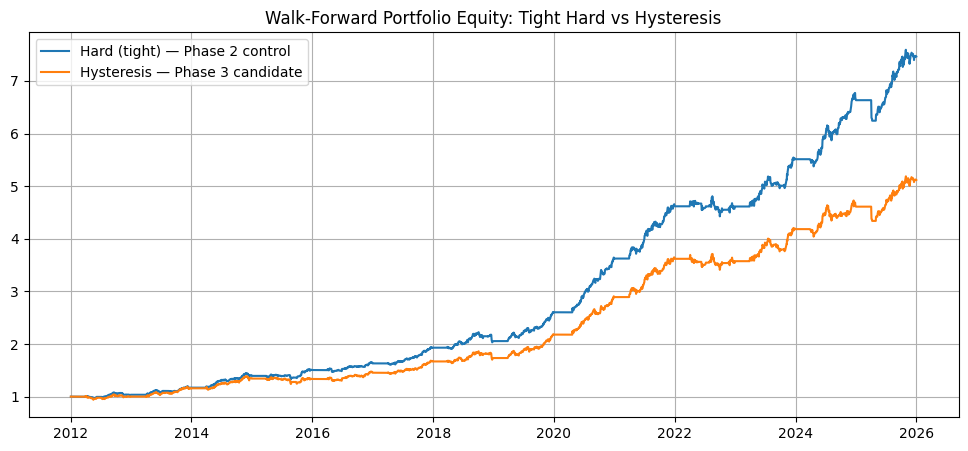

In [7]:
eq_hard = (1 + port_hard["portfolio_ret"]).cumprod()
eq_hyst = (1 + port_hyst["portfolio_ret"]).cumprod()

plt.figure(figsize=(12,5))
plt.plot(port_hard["date"], eq_hard, label="Hard (tight) — Phase 2 control")
plt.plot(port_hyst["date"], eq_hyst, label="Hysteresis — Phase 3 candidate")
plt.title("Walk-Forward Portfolio Equity: Tight Hard vs Hysteresis")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
def yearly_summary(portfolio_daily: pd.DataFrame, label: str) -> pd.DataFrame:
    rows = []
    for y, g in portfolio_daily.groupby("year"):
        eq = (1 + g["portfolio_ret"]).cumprod().values
        rows.append({
            "year": y,
            f"sharpe_{label}": sharpe_ratio(g["portfolio_ret"].values),
            f"ret_{label}": eq[-1] - 1.0,
            f"mdd_{label}": max_drawdown(eq),
            f"avgLev_{label}": g["portfolio_lev"].mean(),
        })
    return pd.DataFrame(rows).sort_values("year").reset_index(drop=True)

sum_hard = yearly_summary(port_hard, "hard")
sum_hyst = yearly_summary(port_hyst, "hyst")

compare = sum_hard.merge(sum_hyst, on="year", how="inner")
compare["sharpe_diff"] = compare["sharpe_hyst"] - compare["sharpe_hard"]
compare["mdd_diff"] = compare["mdd_hyst"] - compare["mdd_hard"]
compare


,year,sharpe_hard,ret_hard,mdd_hard,avgLev_hard,sharpe_hyst,ret_hyst,mdd_hyst,avgLev_hyst,sharpe_diff,mdd_diff
0,2012,0.650502,0.035983,-0.047791,0.920160,0.057180,0.001564,-0.070146,0.902995,-0.593322,-0.022356
1,2013,2.080086,0.130002,-0.043109,0.917379,2.226937,0.156590,-0.049974,0.914909,0.146851,-0.006865
2,2014,2.751054,0.191062,-0.042818,0.924247,1.971393,0.159715,-0.054168,0.901806,-0.779660,-0.011349
3,2015,1.056412,0.079806,-0.066821,0.845451,-0.026614,-0.005680,-0.093383,0.807135,-1.083026,-0.026562
4,2016,1.478474,0.083897,-0.041589,0.920772,1.292256,0.088909,-0.044085,0.918933,-0.186218,-0.002496
5,2017,2.703922,0.182890,-0.023836,0.919217,2.104099,0.147270,-0.023836,0.919217,-0.599823,0.000000
6,2018,0.829372,0.064804,-0.086890,0.887915,0.487563,0.038934,-0.085922,0.865010,-0.341809,0.000968
7,2019,3.183630,0.266496,-0.045717,0.864306,2.952485,0.256734,-0.047093,0.839274,-0.231146,-0.001376
8,2020,3.907225,0.392016,-0.025602,0.737269,3.264634,0.327175,-0.036623,0.686066,-0.642591,-0.011021
9,2021,2.868887,0.274072,-0.031695,0.851948,2.598868,0.251568,-0.036904,0.821273,-0.270019,-0.005209


In [9]:
def churn_per_asset(diag: pd.DataFrame) -> pd.DataFrame:
    out = []
    for asset, g in diag.groupby("asset"):
        g = g.sort_values("date")
        churn = (g["state"] != g["state"].shift()).sum()
        out.append({"asset": asset, "state_changes": churn})
    return pd.DataFrame(out).sort_values("asset").reset_index(drop=True)

churn_hard = churn_per_asset(diag_hard).rename(columns={"state_changes": "hard_state_changes"})
churn_hyst = churn_per_asset(diag_hyst).rename(columns={"state_changes": "hyst_state_changes"})

churn_hard.merge(churn_hyst, on="asset")


,asset,hard_state_changes,hyst_state_changes
0,AAPL,351,194
1,MSFT,392,225
2,SPY,337,153
